In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.utils import shuffle
from tensorflow import keras
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Layer, Input

True function, $f(x)$

In [2]:
def f(x):
    return np.sin(0.25*x)

True function plus noise that varies with $x$, $g(x)$

In [3]:
sigma_0 = 0.01
samples = 50
def g(x):
    return np.random.normal(f(x), sigma_0*x, samples)

Visualizing $g(x)$

In [4]:
x_vals = np.arange(0,12*np.pi + np.pi/4, np.pi/4)
x_arr = np.array([])
y_arr = np.array([])
for x in x_vals:
    x_arr = np.append(x_arr, np.full(samples,x))
    y_arr = np.append(y_arr, g(x))
x_arr, y_arr = shuffle(x_arr, y_arr)

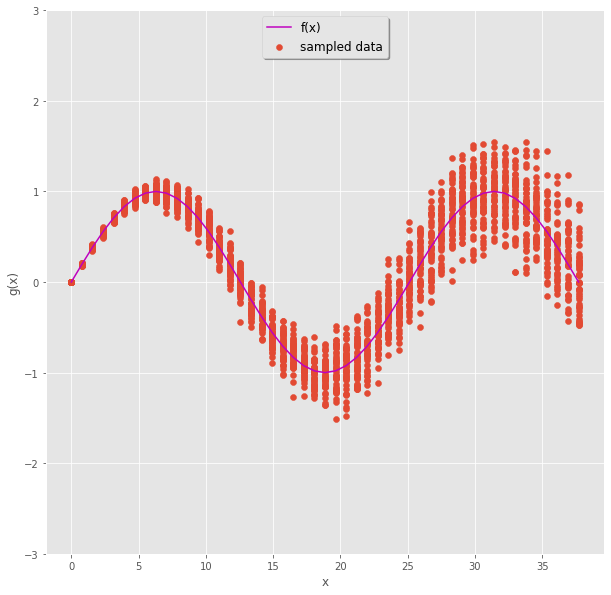

In [5]:
fig, ax = plt.subplots(figsize=(10,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('g(x)')
ax.scatter(x_arr,y_arr,label='sampled data')
ax.plot(x_vals,list(map(f,x_vals)),c='m',label='f(x)')
ax.legend(loc='upper center',fontsize='large',shadow=True)
plt.ylim(-3, 3)
plt.show()

Training simple 2-layer dense network to estimate $\hat f(x)$

In [6]:
epochs = 500
batch_size = 50
learning_rate = 0.0003
model = Sequential()
model.add(Dense(12,input_shape=(1,),activation="tanh"))
model.add(Dense(12,activation="tanh"))
model.add(Dense(1,activation="linear"))

adamOptimizer = optimizers.Adam(learning_rate=learning_rate)
model.compile(loss='mse',optimizer=adamOptimizer,metrics=['mse'])

In [7]:
history_cache = model.fit(x_arr,
                          y_arr,
                          verbose=0, # write =1 if you wish to see the progress for each epoch
                          epochs=epochs,
                          batch_size=batch_size)

_, final_mse = model.evaluate(x_arr, y_arr, batch_size=batch_size)

49/49 [==============================] - 0s 839us/step - loss: 0.0973 - mse: 0.0973


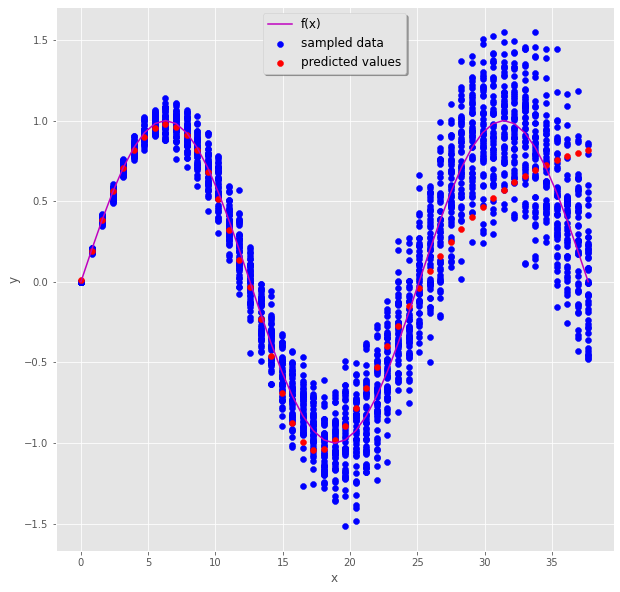

Final cost: 0.0973


In [8]:
y_pred = model.predict(x_vals)
fig, ax = plt.subplots(figsize=(10,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
ax.scatter(x_arr,y_arr,c='b',label='sampled data')
ax.scatter(x_vals,y_pred,c='r',label='predicted values')
ax.plot(x_vals,list(map(f,x_vals)),c='m',label='f(x)')
ax.legend(loc='upper center',fontsize='large',shadow=True)
plt.show()
print('Final cost: {0:.4f}'.format(final_mse))

Convert to MDN,

In [9]:
event_shape = [1]
num_components = 1
params_size = tfp.layers.MixtureNormal.params_size(num_components, event_shape)
print('Params_size:', params_size)

model = Sequential()
model.add(Dense(12,input_shape=(1,),activation="tanh"))
model.add(Dense(12,activation="tanh"))
model.add(Dense(params_size, activation=None))
model.add(tfp.layers.MixtureNormal(num_components, event_shape,
                                   convert_to_tensor_fn=lambda X: tf.concat([tfp.distributions.Distribution.mean(X), tfp.distributions.Distribution.stddev(X)],1)))

model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
              loss=lambda y, model: -model.log_prob(y))

Params_size: 3


In [10]:
history_cache = model.fit(x_arr,
                          y_arr,
                          verbose=0, # write =1 if you wish to see the progress for each epoch
                          epochs=epochs,
                          batch_size=batch_size)

final_mse = model.evaluate(x_arr, y_arr, batch_size=batch_size)

49/49 [==============================] - 0s 889us/step - loss: -0.3761


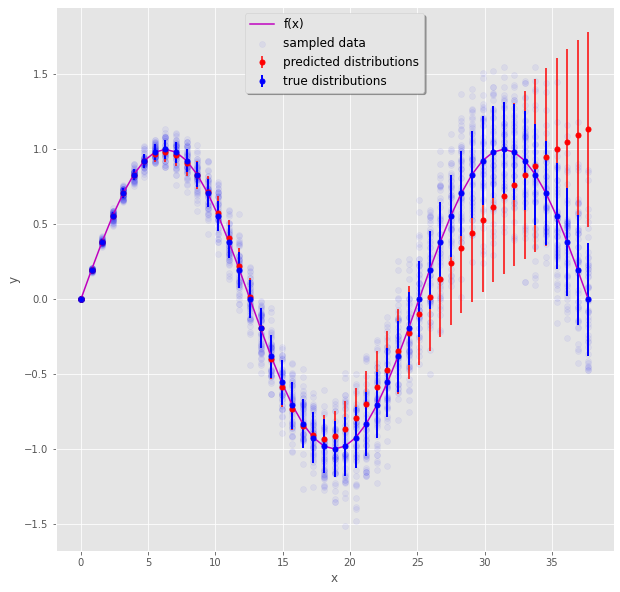

In [11]:
# mu_pred, sigma_pred = model.predict(list((x_vals,x_vals))) # the model expects a list of arrays as it has 2 inputs
pred = model.predict(x_vals)
mu_pred = pred[:,0]
sigma_pred = pred[:,1]
fig, ax = plt.subplots(figsize=(10,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
ax.errorbar(x_vals,mu_pred,yerr=np.absolute(sigma_pred),c='r',ls='None',marker='.',ms=10,label='predicted distributions')
# ax.errorbar(x_vals,mu_pred,c='r',ls='None',marker='.',ms=10,label='predicted distributions')
ax.scatter(x_arr,y_arr,c='b',alpha=0.05,label='sampled data')
ax.errorbar(x_vals,list(map(f,x_vals)),yerr=list(map(lambda x: sigma_0*x,x_vals)),c='b',lw=2,ls='None',marker='.',ms=10,label='true distributions')
ax.plot(x_vals,list(map(f,x_vals)),c='m',label='f(x)')
ax.legend(loc='upper center',fontsize='large',shadow=True)
plt.show()